In [6]:
import ee
from drought.data import ee_climate, pipeline
from drought.visualization import plot
import drought.data.df_extensions as dfext
import geemap
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa import seasonal
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from scipy import fftpack
from scipy.fft import fft, fftfreq

In [3]:
ee.Initialize()

## Climate Seasonal Analysis

In [4]:
# Dates of interest.
start_date_str = '2010-01-01'
end_date_str = '2022-11-01'

In [5]:
# Dates of interest.
start_date = ee.Date(start_date_str)
end_date = ee.Date(end_date_str)

# Get regions of interest.
ee_geoms = pipeline.get_ee_polygons()

# Specify resolution.
scale = 20000

# Fetch climate data from Earth Engine as Pandas DataFrame.
precip_df = ee_climate.get_monthly_climate_data_as_pdf(
        start_date, end_date, ee_geoms, scale, columns=['precipitation', 'ET', 'PET'])

In [9]:
radiation_pdf = ee_climate.get_monthly_climate_data_as_pdf(
        start_date, end_date, ee_geoms, scale, columns=['temperature', 'radiation', 'fpar'])

In [7]:
precip_monthly_mean = precip_df.groupby(['month', 'polygon_id', 'year']) \
                               .mean(numeric_only=True).reset_index()
precip_monthly_mean = dfext.add_datetime_column(precip_monthly_mean)
precip_monthly_mean['water_deficit'] = precip_monthly_mean['precipitation'] - precip_monthly_mean['PET']

In [10]:
radiation_monthly_mean = radiation_pdf.groupby(['month', 'polygon_id', 'year']) \
                                      .mean(numeric_only=True).reset_index()
radiation_monthly_mean = dfext.add_datetime_column(radiation_monthly_mean)

In [8]:
precip_monthly_mean.to_csv('../../data/interim/monthly_means_timeseries_of_water_climate_vars_01-2010_to_11-2022.csv')

In [11]:
radiation_monthly_mean.to_csv('../../data/interim/monthly_means_timeseries_of_radiation_vars_01-2010_to_11-2022.csv')

In [17]:
climate_df = precip_monthly_mean.set_index(['month', 'polygon_id', 'year', 'datetime']) \
                                .join(radiation_monthly_mean.set_index(['month', 'polygon_id', 'year', 'datetime'])) \
                                .reset_index()

In [ ]:
climate_df.to_csv('../../data/interim/monthly_means_timeseries_of_climate_vars_01-2010_to_11-2022.csv')

### Dry Season

In [157]:
# First, we will try to detect a beginning of dry season using "The dry season is defined with monthly precipitation less than either 100 mm or one-third of the annual precipitation range"
import seaborn as sns
def plot_annual_precipitation(df, polygon_id):
    polygon_df = df[df.polygon_id == polygon_id]
    yearly = polygon_df.groupby('year').sum().reset_index()
    sns.lineplot(x=yearly.year, y=yearly.precipitation)

In [176]:
# First, we will try to detect a beginning of dry season using "The dry season is defined with monthly precipitation less than either 100 mm or one-third of the annual precipitation range"
import seaborn as sns
def get_dry_months(df, polygon_id):
    polygon_df = df[df.polygon_id == polygon_id]
    #for year in range(2013, 2023):
    #    polygon_yearly_df = polygon_df[polygon_df.year == year]
    sns.lineplot(x=polygon_df.month, y=polygon_df.precipitation)
    #plt.boxplot(polygon_yearly_df.precipitation)
    plt.show()

1


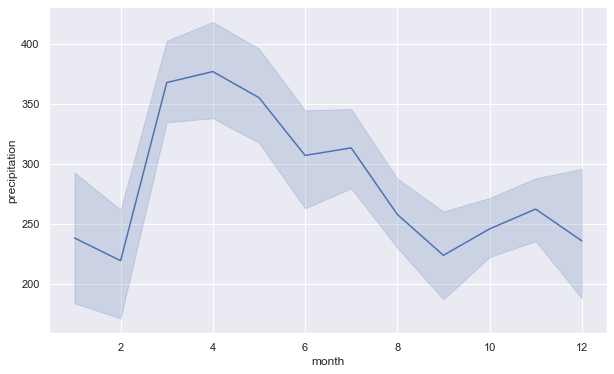

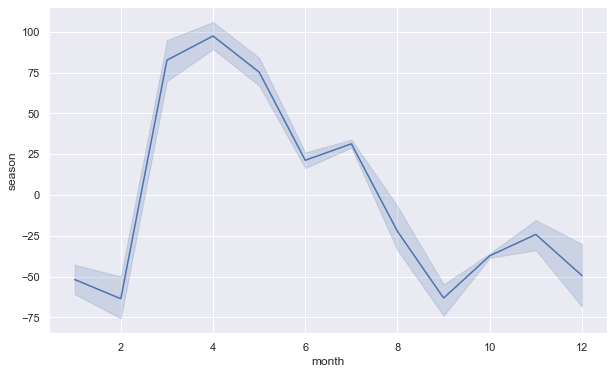

2


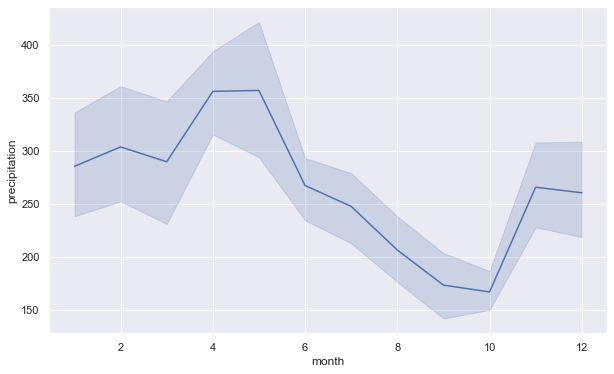

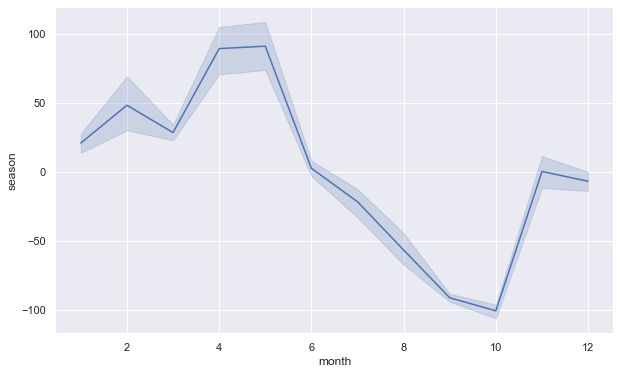

3


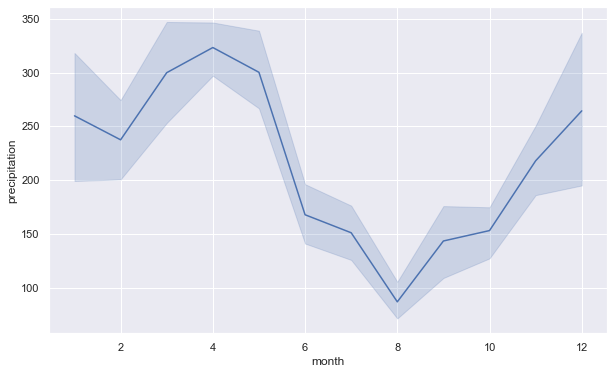

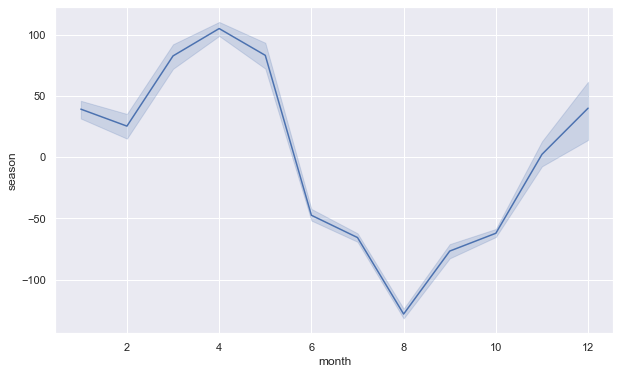

4


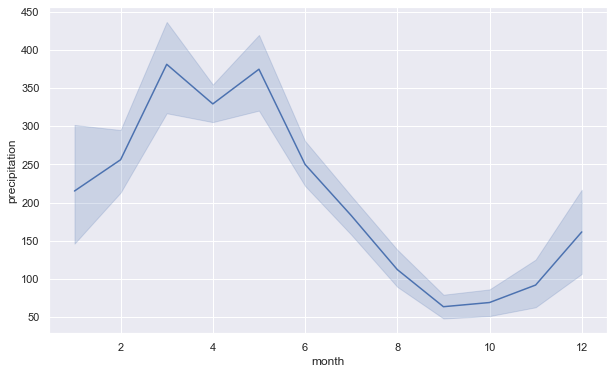

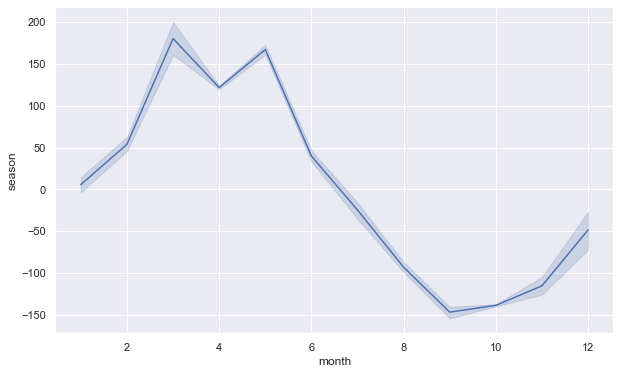

5


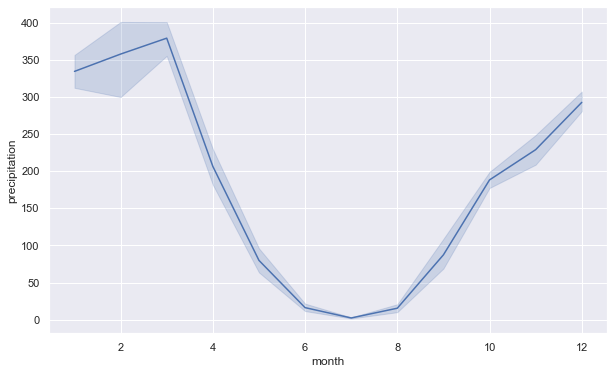

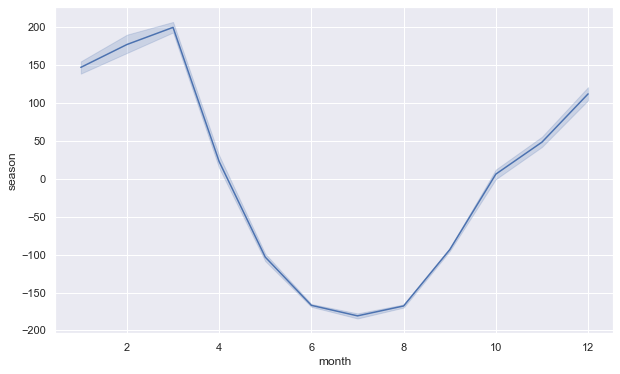

6


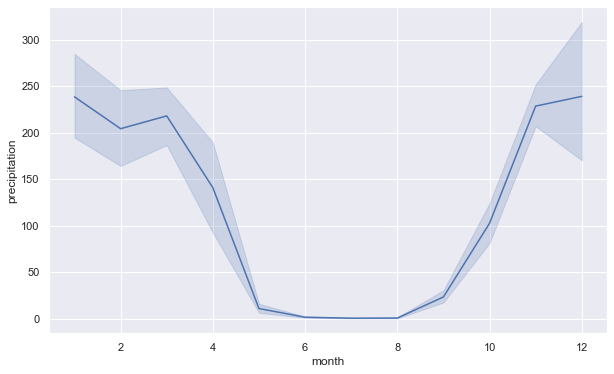

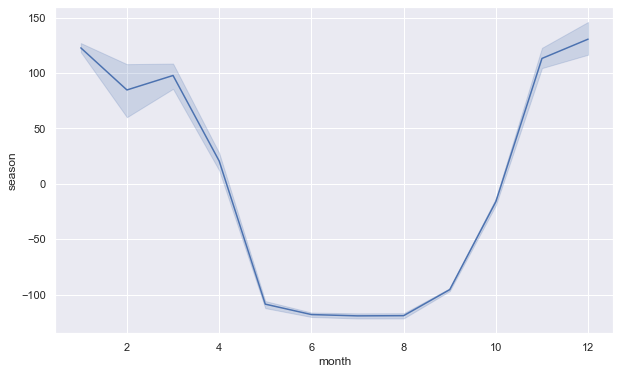

7


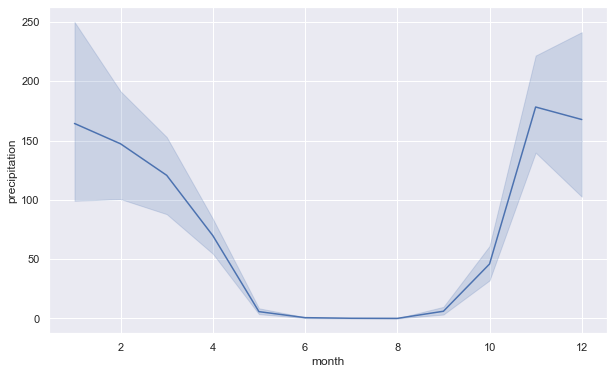

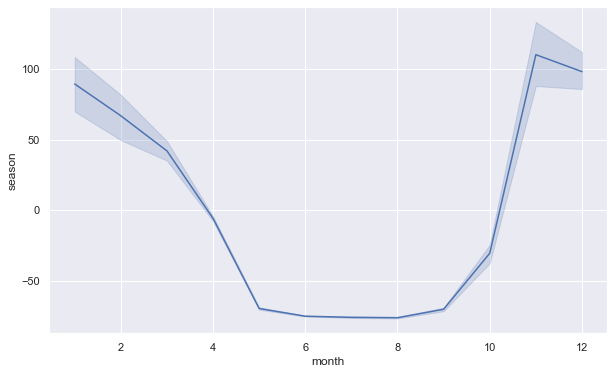

8


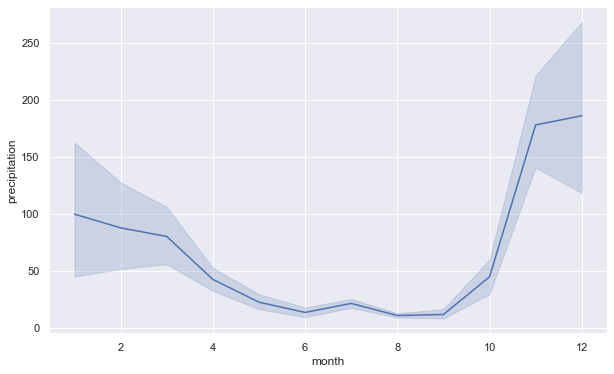

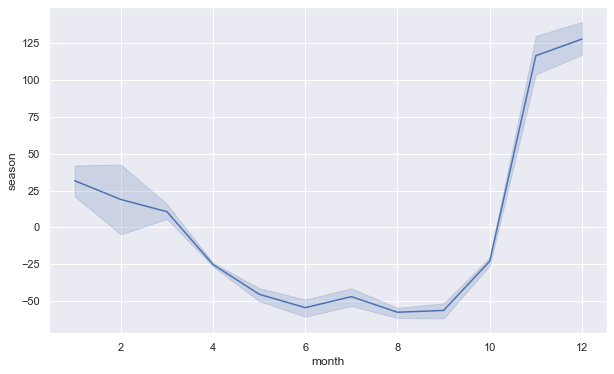

In [200]:
for polygon_id in range(1,9):
    print(polygon_id)
    get_dry_months(precip_monthly_mean, polygon_id)
    get_precipitation_seasonal(precip_monthly_mean, polygon_id)

In [201]:
# Dry season per polygon just eyeballed from the plots. TODO: Refine this
seasons = pd.DataFrame([[1, 9, 12], [2, 6, 10], [3, 6, 10], [4, 8, 11], [5, 5, 9], [6, 5, 10], [7, 4, 10], [8, 3, 10]],
    columns=['polygon_id', 'dry_start', 'dry_end'])
seasons

polygon_id  dry_start  dry_end
0           1          9       12
1           2          6       10
2           3          6       10
3           4          8       11
4           5          5        9
5           6          5       10
6           7          4       10
7           8          3       10

### Methods for doing time series decomposition using statsmodel seasonal

In [33]:
def do_ts_decomposition(df, polygon_id, start_date, end_date, columns):
    polygon_ts = df.loc[df.polygon_id == polygon_id]
    polygon_ts = polygon_ts.sort_values('datetime')
    polygon_ts.index = pd.date_range(start=start_date, end=end_date, freq=pd.offsets.MonthBegin(1))

    decomps = {}
    for column in columns:
        #decomps[column] = seasonal.seasonal_decompose(polygon_ts[[column]], model='additive')
        decomps[column] = STL(polygon_ts[[column]], seasonal=13).fit()

    return decomps

def plot_ts_decompositions(ts_decomp_dict, columns):
    for column in columns:
        plt.rcParams['figure.figsize'] = [10, 6]
        ts_decomp_dict[column].plot()
        plt.show()

### Find missing data in timeseries

In [28]:
import numpy as np
monthly_index = pd.date_range(start=start, end=end, freq=pd.offsets.MonthBegin(1))
dummy_df = pd.DataFrame(np.random.randint(1, 20, (monthly_index.shape[0], 1)))
dummy_df.index = monthly_index

missing_dates = dummy_df.index[~dummy_df.index.isin(precip_monthly_mean.datetime)]
missing_dates

DatetimeIndex(['2022-12-01', '2023-01-01'], dtype='datetime64[ns]', freq='MS')

### Per Polygon decomp of water climate vars

In [34]:
ts_decomps = do_ts_decomposition(precip_monthly_mean, polygon_id=1, start_date=start, end_date=end, columns=['precipitation', 'ET', 'PET', 'water_deficit'])

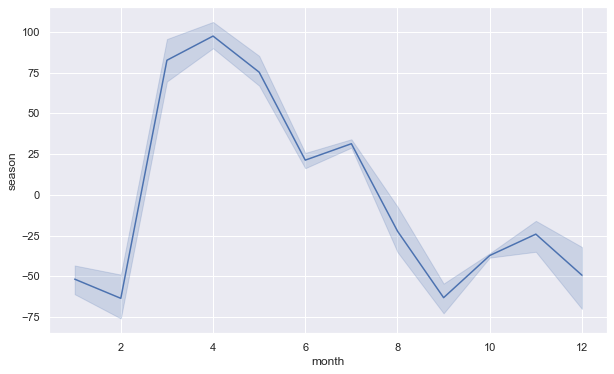

In [190]:
def get_precipitation_seasonal(df, polygon_id):
    decomposed = ts_decomps = do_ts_decomposition(df, polygon_id=polygon_id, start_date=start, end_date=end, columns=['precipitation'])
    p_seasonal = decomposed['precipitation'].seasonal
    p_seasonal_df = pd.DataFrame(p_seasonal)
    p_seasonal_df['year'] = pd.DatetimeIndex(p_seasonal_df.index).year
    p_seasonal_df['month'] = pd.DatetimeIndex(p_seasonal_df.index).month
    sns.lineplot(x=p_seasonal_df.month, y=p_seasonal_df.season)
    #plt.boxplot(polygon_yearly_df.precipitation)
    plt.show()
#plot_ts_decompositions(ts_decomps, columns=['precipitation', 'ET', 'PET', 'water_deficit'])
get_precipitation_seasonal(precip_monthly_mean, 1)

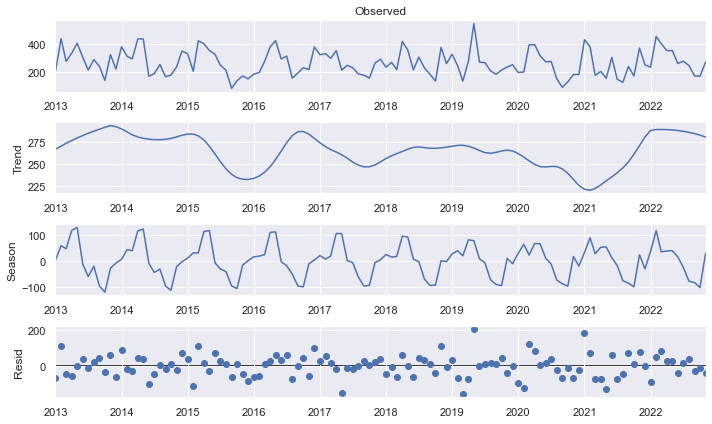

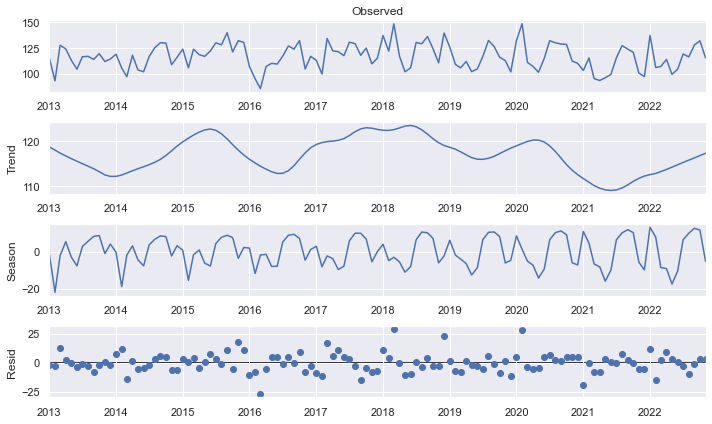

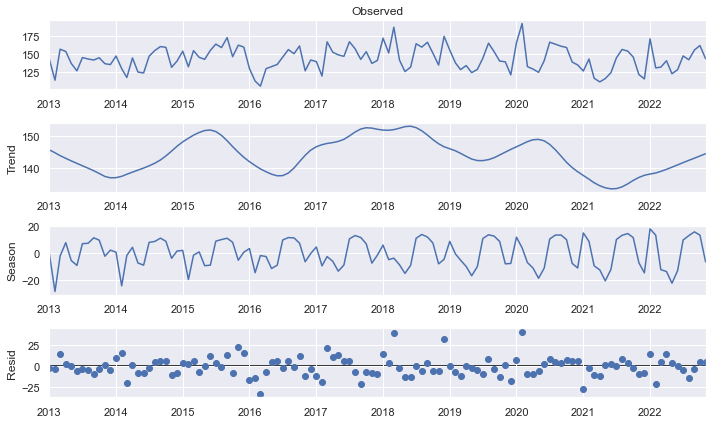

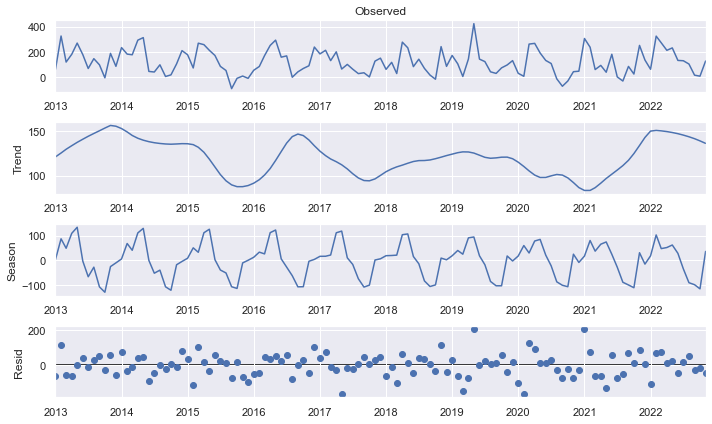

In [36]:
ts_decomps = do_ts_decomposition(precip_monthly_mean, polygon_id=2, start_date=start, end_date=end, columns=['precipitation', 'ET', 'PET', 'water_deficit'])
plot_ts_decompositions(ts_decomps, columns=['precipitation', 'ET', 'PET', 'water_deficit'])

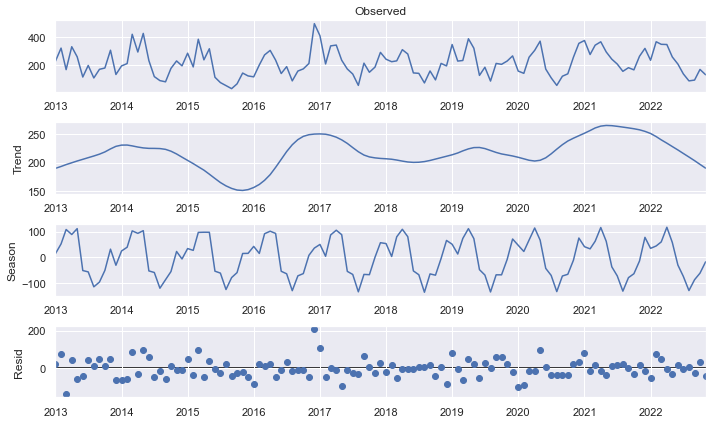

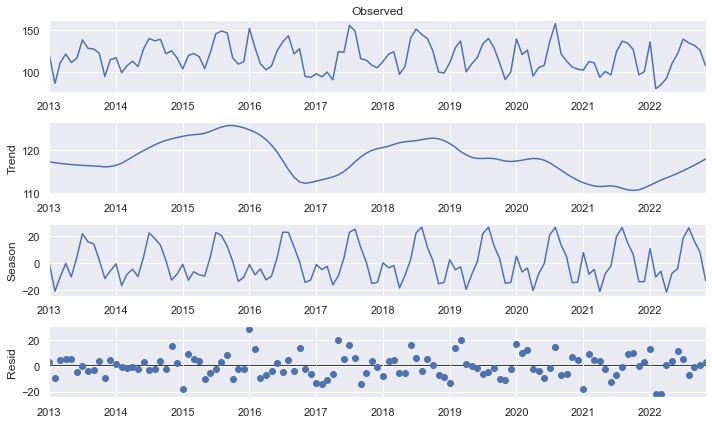

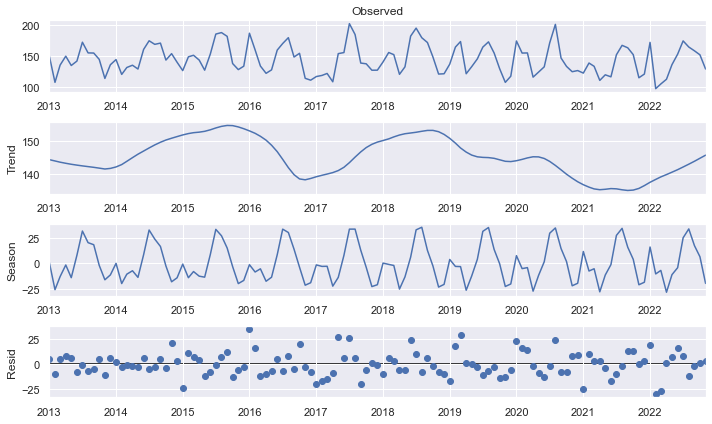

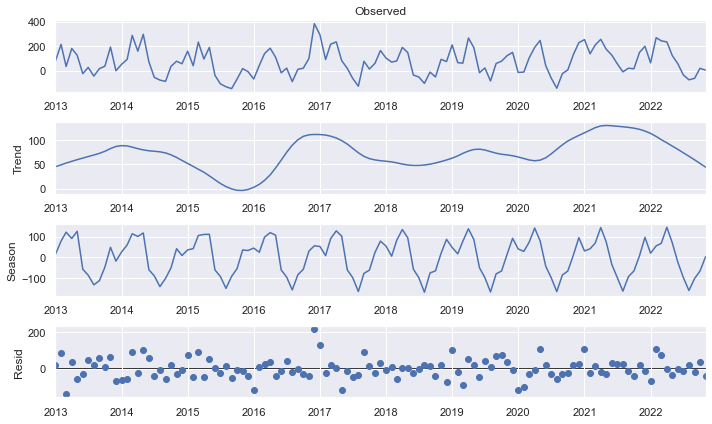

In [37]:
ts_decomps = do_ts_decomposition(precip_monthly_mean, polygon_id=3, start_date=start, end_date=end, columns=['precipitation', 'ET', 'PET', 'water_deficit'])
plot_ts_decompositions(ts_decomps, columns=['precipitation', 'ET', 'PET', 'water_deficit'])

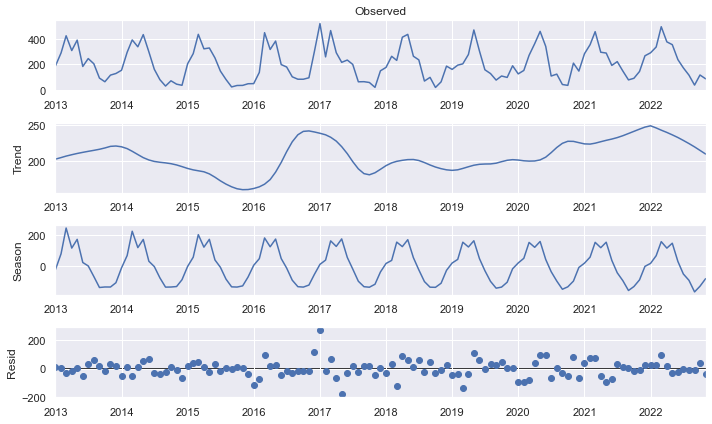

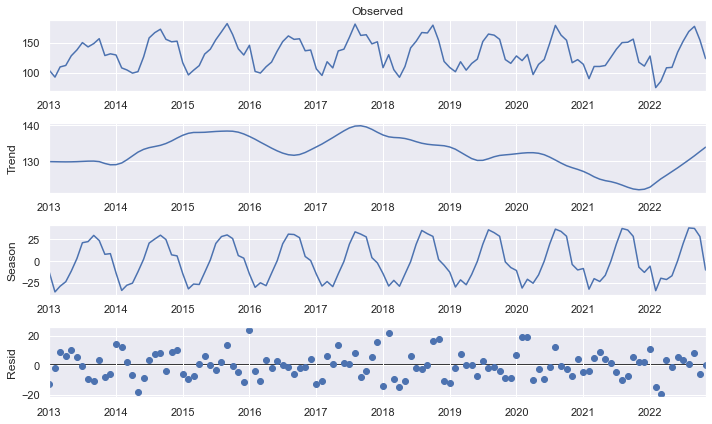

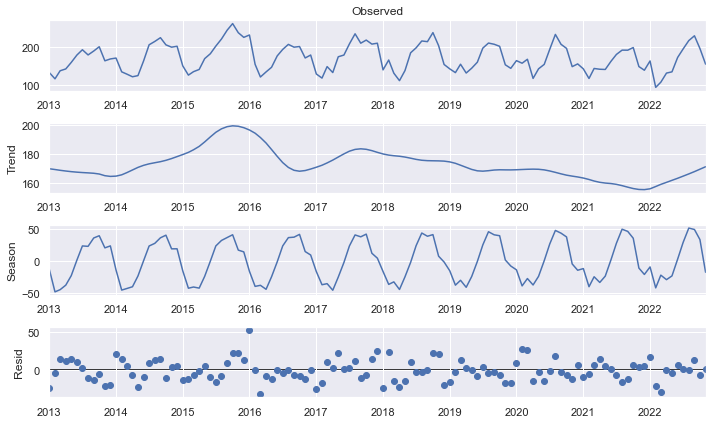

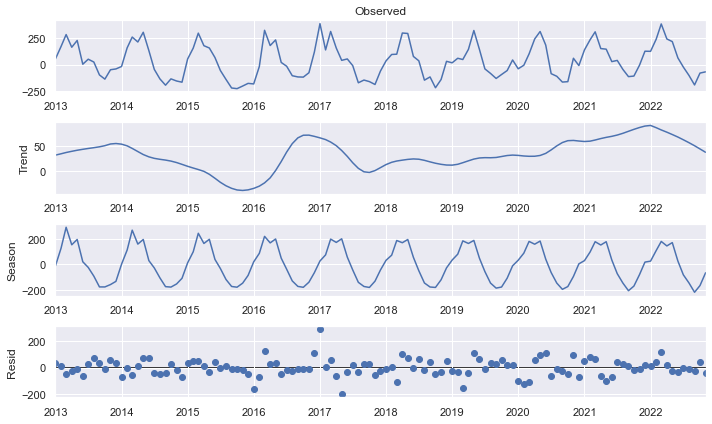

In [38]:
ts_decomps = do_ts_decomposition(precip_monthly_mean, polygon_id=4, start_date=start, end_date=end, columns=['precipitation', 'ET', 'PET', 'water_deficit'])
plot_ts_decompositions(ts_decomps, columns=['precipitation', 'ET', 'PET', 'water_deficit'])

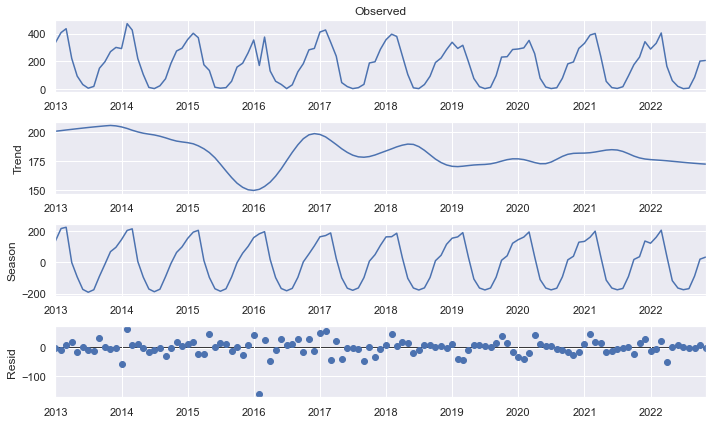

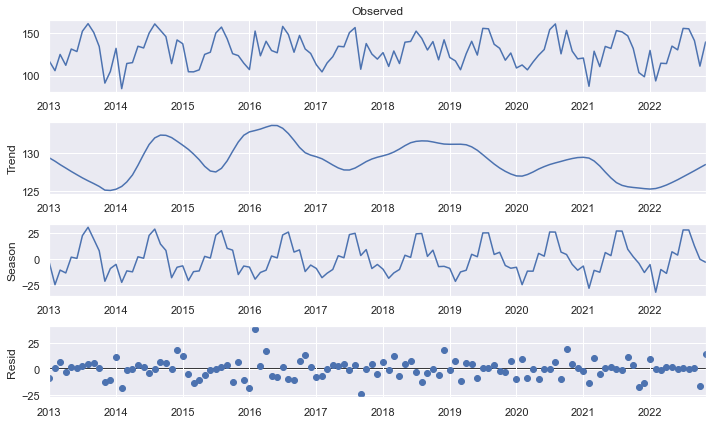

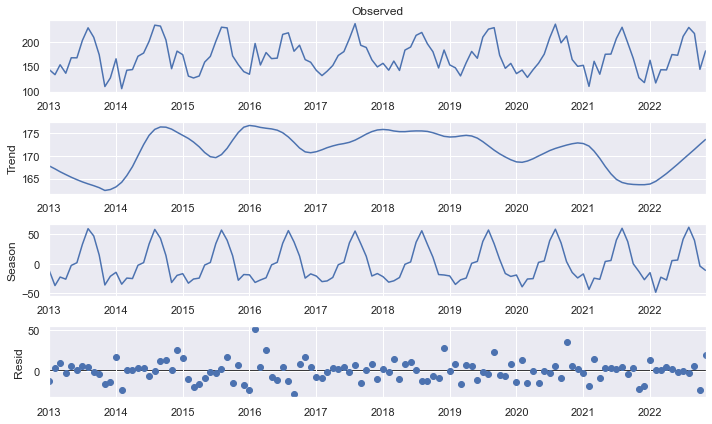

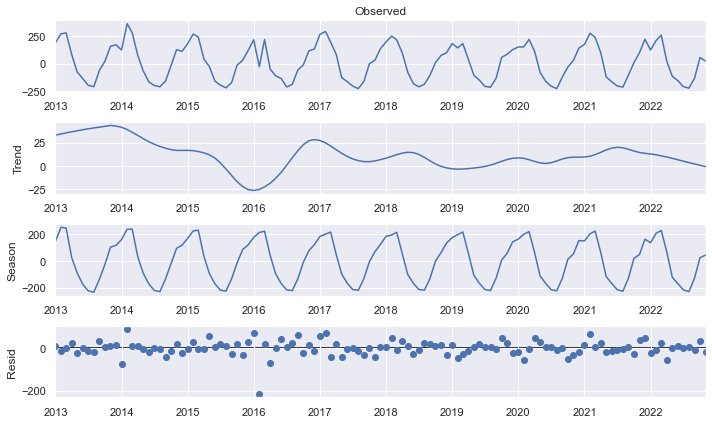

In [39]:
ts_decomps = do_ts_decomposition(precip_monthly_mean, polygon_id=5, start_date=start, end_date=end, columns=['precipitation', 'ET', 'PET', 'water_deficit'])
plot_ts_decompositions(ts_decomps, columns=['precipitation', 'ET', 'PET', 'water_deficit'])

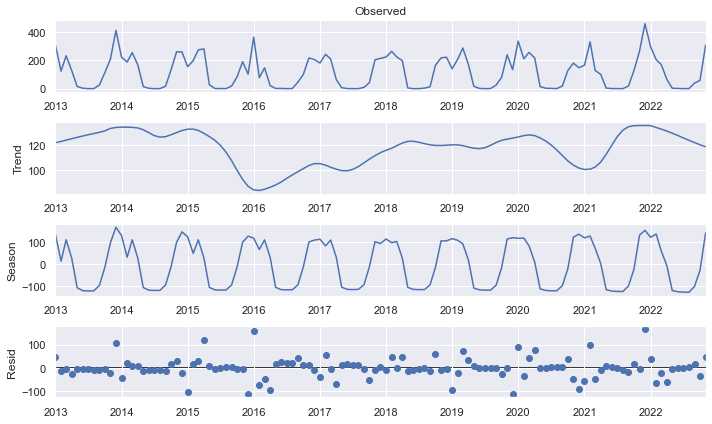

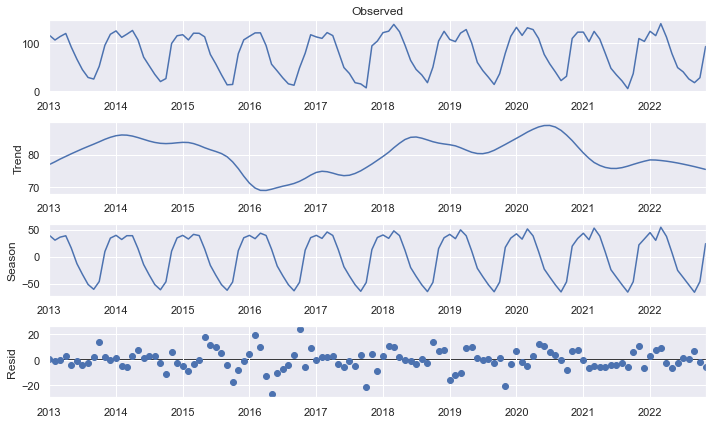

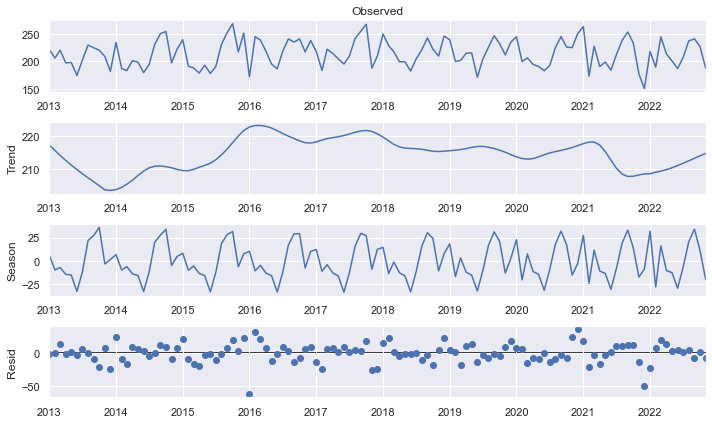

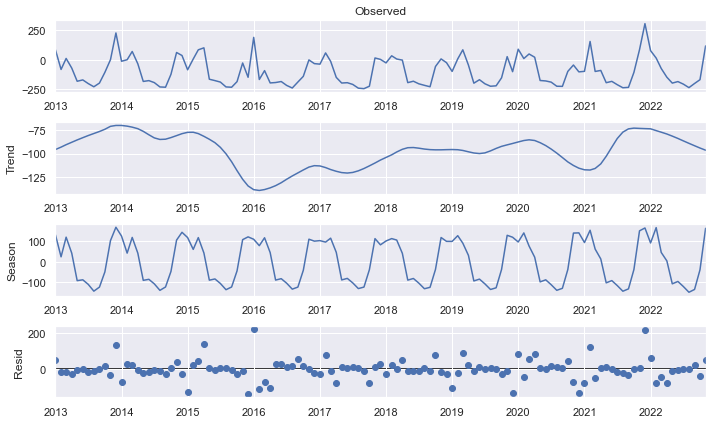

In [40]:
ts_decomps = do_ts_decomposition(precip_monthly_mean, polygon_id=6, start_date=start, end_date=end, columns=['precipitation', 'ET', 'PET', 'water_deficit'])
plot_ts_decompositions(ts_decomps, columns=['precipitation', 'ET', 'PET', 'water_deficit'])

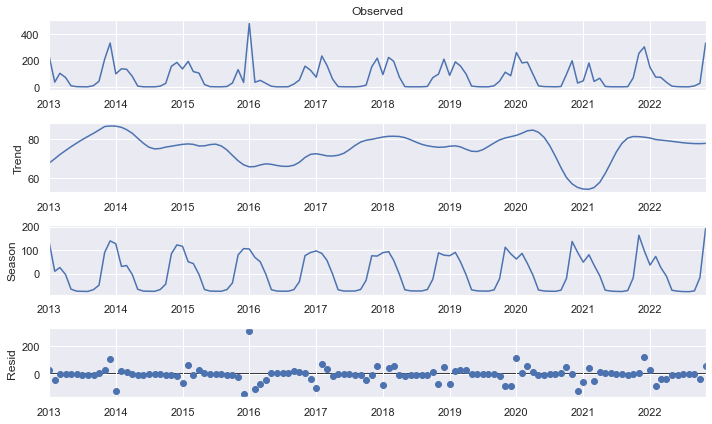

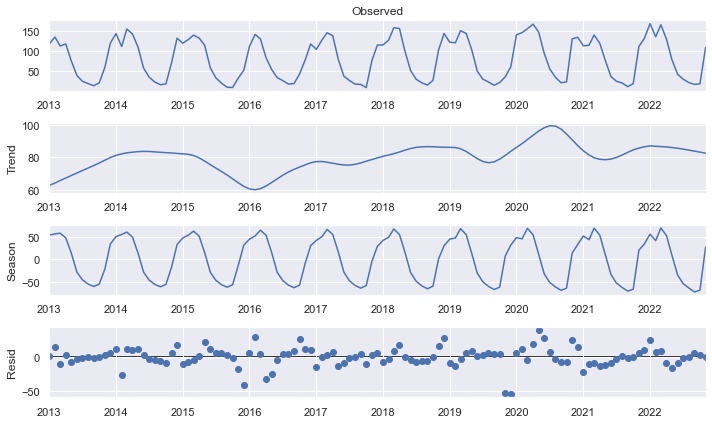

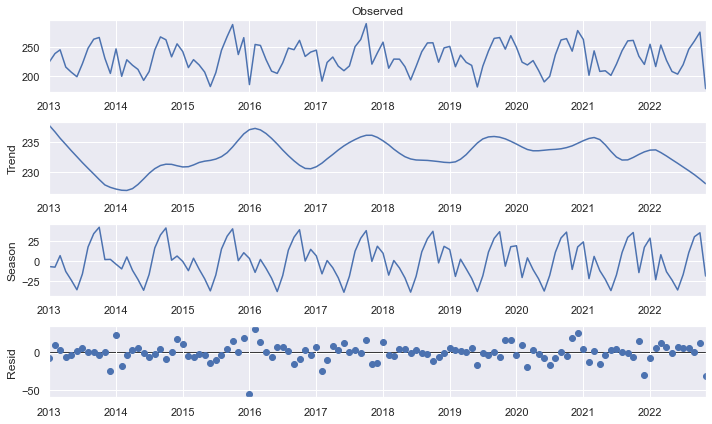

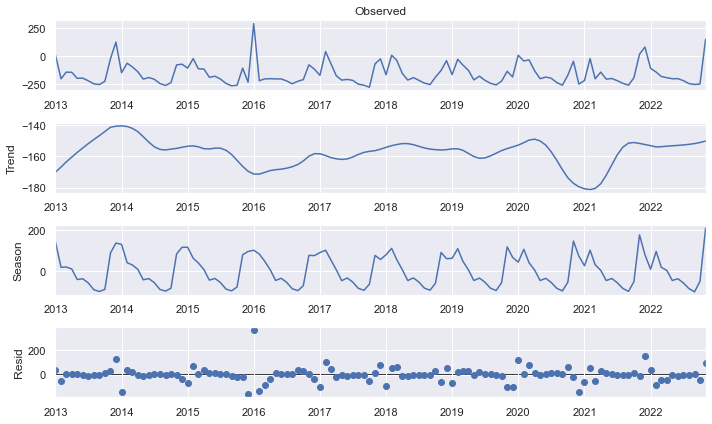

In [41]:
ts_decomps = do_ts_decomposition(precip_monthly_mean, polygon_id=7, start_date=start, end_date=end, columns=['precipitation', 'ET', 'PET', 'water_deficit'])
plot_ts_decompositions(ts_decomps, columns=['precipitation', 'ET', 'PET', 'water_deficit'])

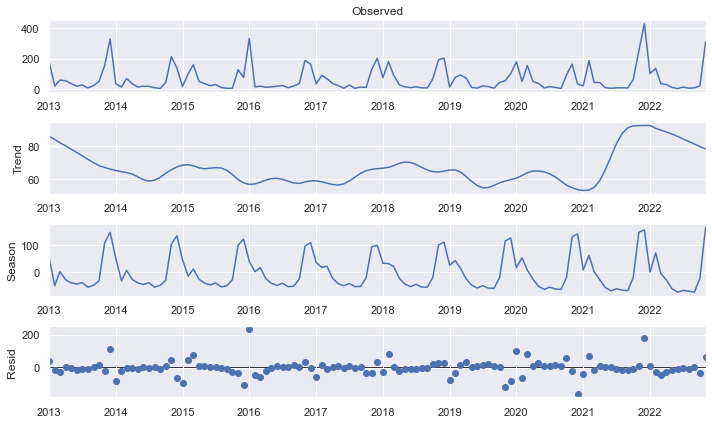

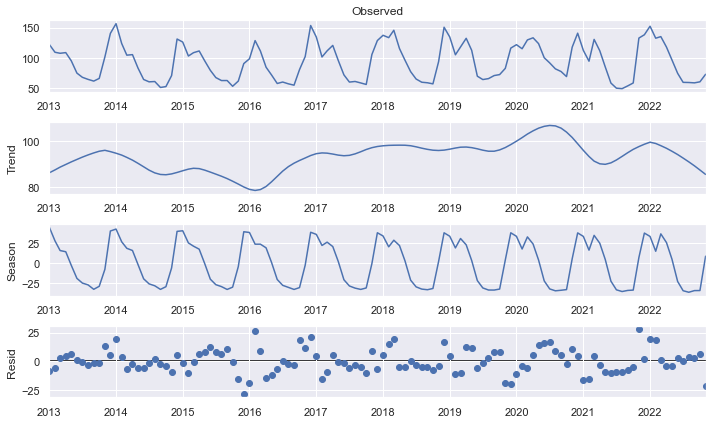

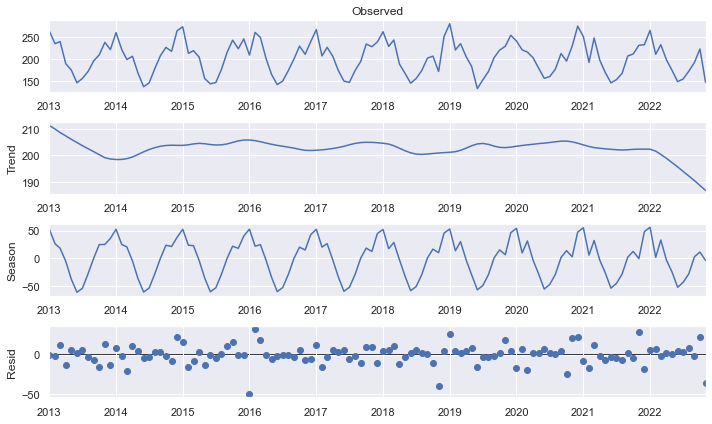

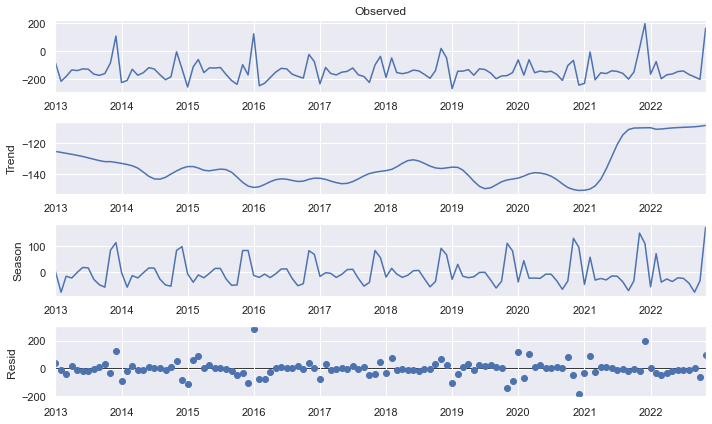

In [42]:
ts_decomps = do_ts_decomposition(precip_monthly_mean, polygon_id=8, start_date=start, end_date=end, columns=['precipitation', 'ET', 'PET', 'water_deficit'])
plot_ts_decompositions(ts_decomps, columns=['precipitation', 'ET', 'PET', 'water_deficit'])

## Seasonal decomposition using Fourier

In [120]:
def plot_fft(df, polygon_id, column):
    ts = df[df.polygon_id==polygon_id].sort_values('datetime')[column].to_numpy()
    y_fft = fftpack.fft(ts - ts.mean())
    xf = fftfreq(119, 1/12)
    return y_fft
    #plt.stem(xf, np.abs(y_fft))
    #plt.show()

[]

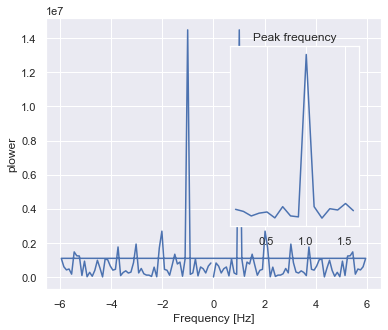

In [142]:
# The FFT of the signal
time_step = 1
y = precip_monthly_mean[precip_monthly_mean.polygon_id==1].sort_values('datetime').precipitation.to_numpy()
sig_fft = fftpack.fft(y - y.mean())

# And the power (sig_fft is of complex dtype)
power = np.abs(sig_fft)**2
period = 24

# The corresponding frequencies
sample_freq = fftpack.fftfreq(119, d=1/12)

# Plot the FFT power
plt.figure(figsize=(6, 5))
plt.plot(sample_freq, power)
plt.xlabel('Frequency [Hz]')
plt.ylabel('plower')

# Find the peak frequency: we can focus on only the positive frequencies
pos_mask = np.where(sample_freq > 0)
freqs = sample_freq[pos_mask]
peak_freq = freqs[power[pos_mask].argmax()]

# Check that it does indeed correspond to the frequency that we generate
# the signal with
np.allclose(peak_freq, 1./period)

# An inner plot to show the peak frequency
axes = plt.axes([0.55, 0.3, 0.3, 0.5])
plt.title('Peak frequency')
plt.plot(freqs[:16], power[pos_mask][:16])
plt.setp(axes, yticks=[])

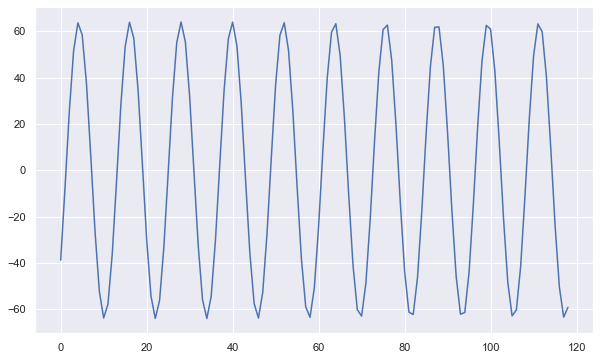

In [146]:
high_freq_fft = sig_fft.copy()
high_freq_fft[np.abs(sample_freq) != peak_freq] = 0
filtered_sig = fftpack.ifft(high_freq_fft)
plt.plot(filtered_sig)
#plt.stem(sample_freq, np.abs(high_freq_fft))
#plt.show()
#filtered_sig = fftpack.ifft(high_freq_fft)

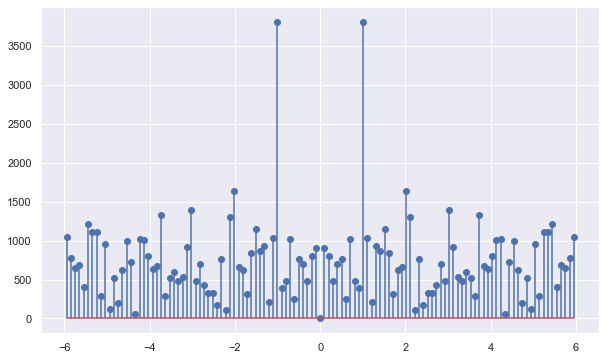

19.833333333333332

In [127]:
SAMPLE_RATE = 12
xf = fftfreq(119, 1/12)
points_per_freq = len(xf) / (SAMPLE_RATE / 2)
target_idx = int(points_per_freq * 100)
yf = plot_fft(precip_monthly_mean, 1, 'precipitation')
yf[target_idx - 1 : target_idx + 2] = 0

plt.stem(xf, np.abs(yf))
plt.show()
points_per_freq

(721.0310121974435+558.0401511314665j)


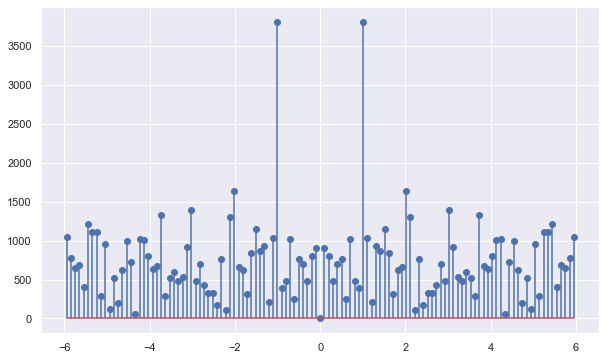

(887.9975141590828+357.25437750561576j)


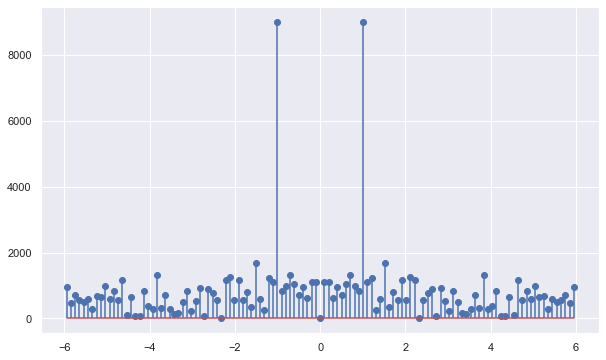

(757.2617525841582+475.0615521019139j)


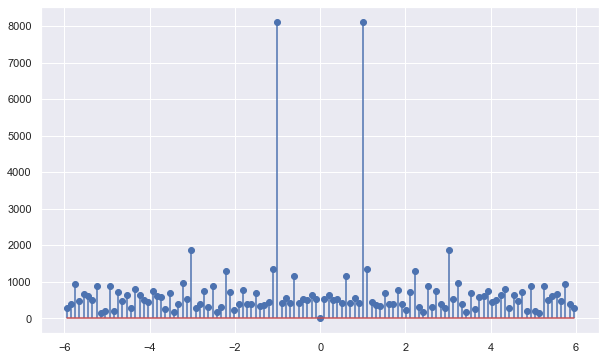

(762.2915863887225+294.2449282236661j)


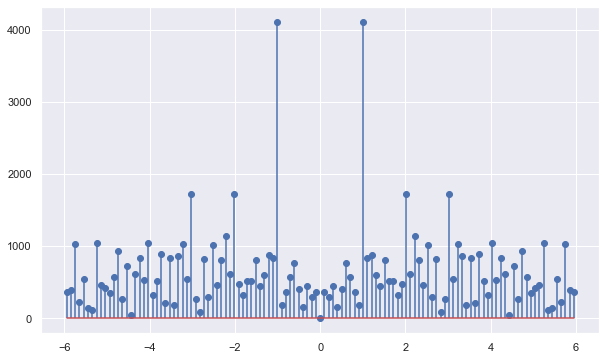

In [117]:
plot_fft(precip_monthly_mean, 1, 'precipitation')
plot_fft(precip_monthly_mean, 4, 'precipitation')
plot_fft(precip_monthly_mean, 6, 'precipitation')
plot_fft(precip_monthly_mean, 8, 'precipitation')

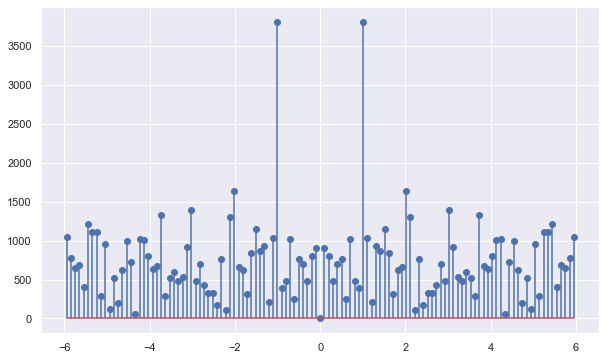

In [104]:
plot_fft(precip_monthly_mean, 8, 'precipitation')

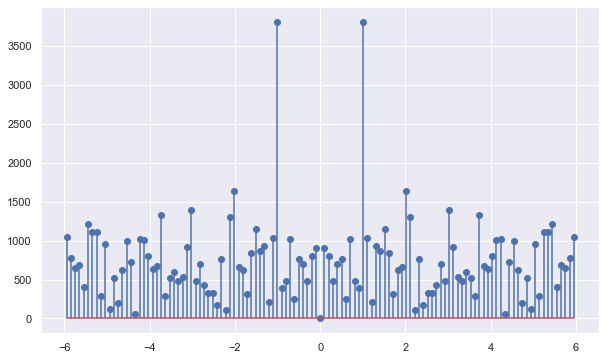

In [96]:
precip_ts = precip_monthly_mean[precip_monthly_mean.polygon_id==1].sort_values('datetime').precipitation.to_numpy()
y_fft = fftpack.fft(precip_ts - precip_ts.mean())
xf = fftfreq(119, 1/12)
plt.stem(xf, np.abs(y_fft))
plt.show()

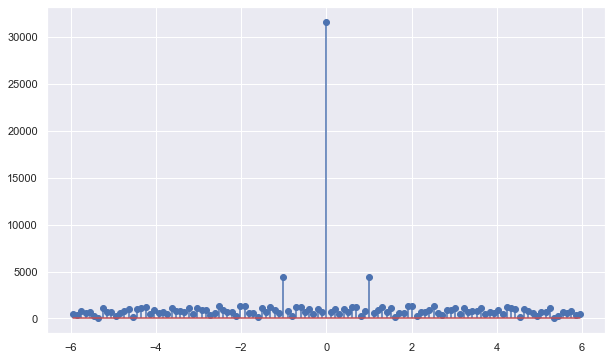

In [88]:
precip_ts = precip_monthly_mean[precip_monthly_mean.polygon_id==2].sort_values('datetime').precipitation.to_numpy()
y_fft = fftpack.fft(precip_ts)
xf = fftfreq(119, 1/12)
plt.stem(xf, np.abs(y_fft))
plt.show()

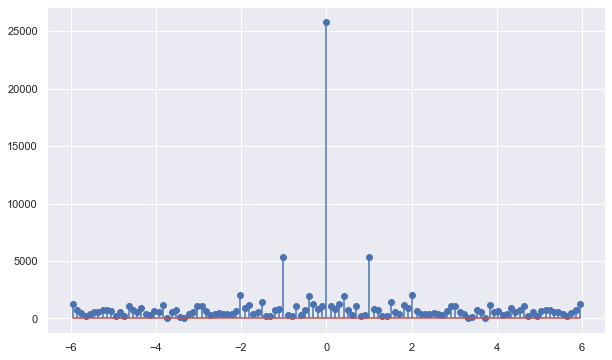

In [89]:
precip_ts = precip_monthly_mean[precip_monthly_mean.polygon_id==3].sort_values('datetime').precipitation.to_numpy()
y_fft = fftpack.fft(precip_ts)
xf = fftfreq(119, 1/12)
plt.stem(xf, np.abs(y_fft))
plt.show()

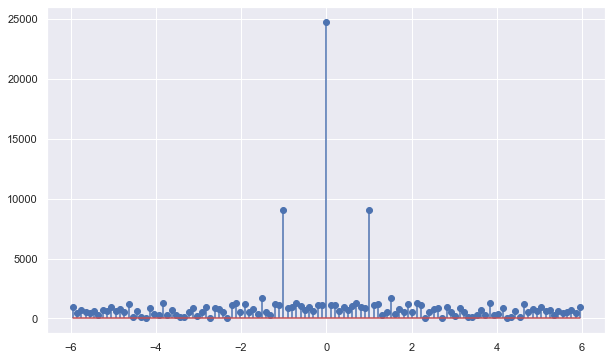

In [90]:
precip_ts = precip_monthly_mean[precip_monthly_mean.polygon_id==4].sort_values('datetime').precipitation.to_numpy()
y_fft = fftpack.fft(precip_ts)
xf = fftfreq(119, 1/12)
plt.stem(xf, np.abs(y_fft))
plt.show()

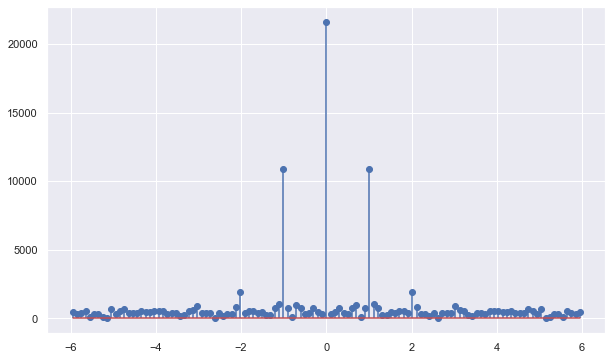

In [91]:
precip_ts = precip_monthly_mean[precip_monthly_mean.polygon_id==5].sort_values('datetime').precipitation.to_numpy()
y_fft = fftpack.fft(precip_ts)
xf = fftfreq(119, 1/12)
plt.stem(xf, np.abs(y_fft))
plt.show()

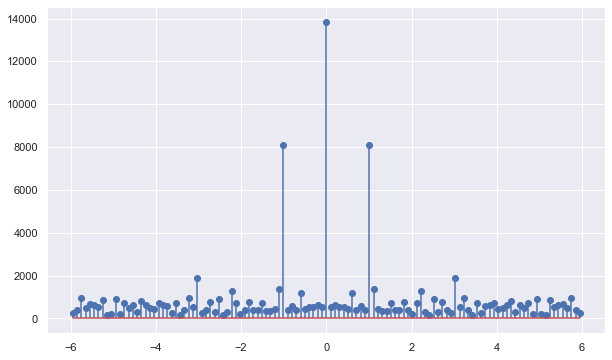

In [92]:
precip_ts = precip_monthly_mean[precip_monthly_mean.polygon_id==6].sort_values('datetime').precipitation.to_numpy()
y_fft = fftpack.fft(precip_ts)
xf = fftfreq(119, 1/12)
plt.stem(xf, np.abs(y_fft))
plt.show()

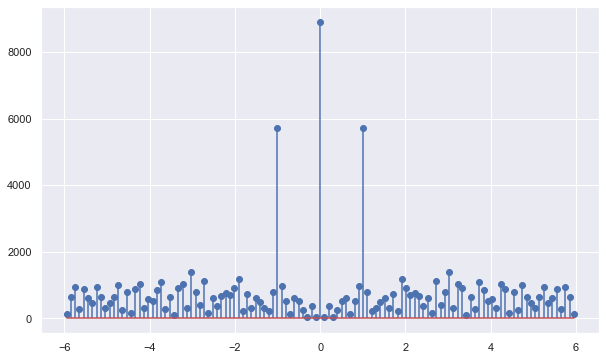

In [93]:
precip_ts = precip_monthly_mean[precip_monthly_mean.polygon_id==7].sort_values('datetime').precipitation.to_numpy()
y_fft = fftpack.fft(precip_ts)
xf = fftfreq(119, 1/12)
plt.stem(xf, np.abs(y_fft))
plt.show()

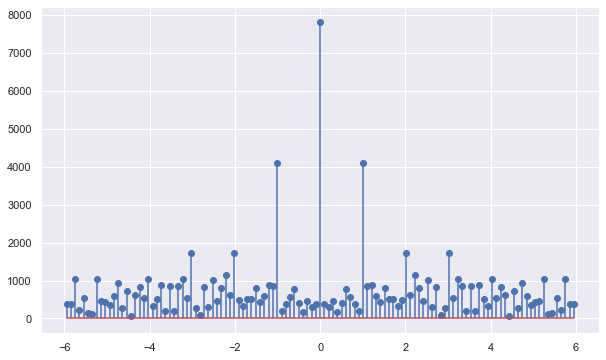

In [94]:
precip_ts = precip_monthly_mean[precip_monthly_mean.polygon_id==8].sort_values('datetime').precipitation.to_numpy()
y_fft = fftpack.fft(precip_ts)
xf = fftfreq(119, 1/12)
plt.stem(xf, np.abs(y_fft))
plt.show()

## Seasonal Decomposition for Polygon 2

In [133]:
ts_decomps = do_ts_decomposition(monthly_data, polygon_id=2, start_date=start_date, end_date=end_date, columns=['radiation', 'precipitation', 'pai', 'temperature'])

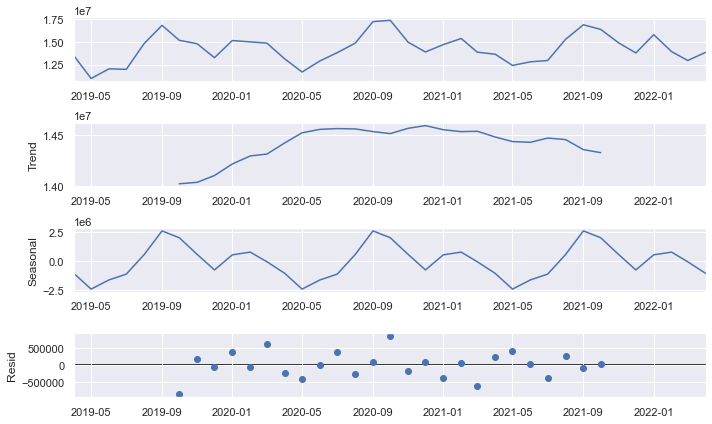

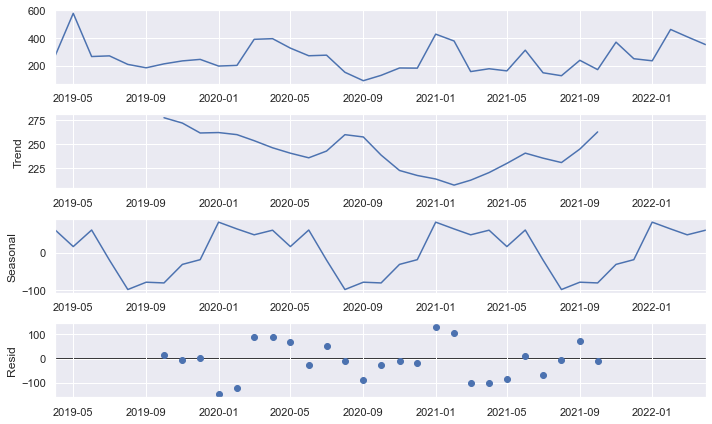

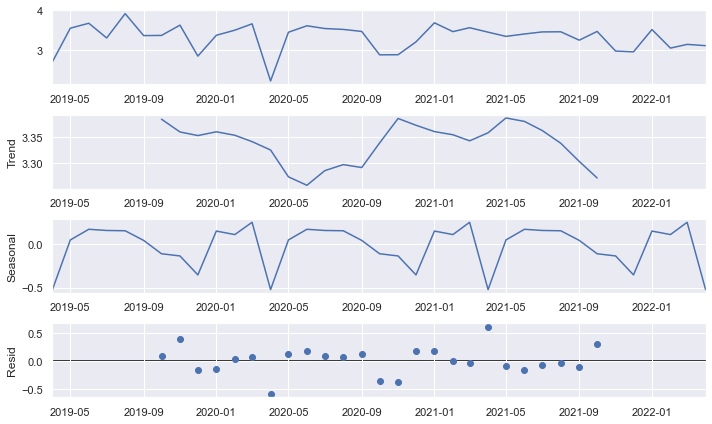

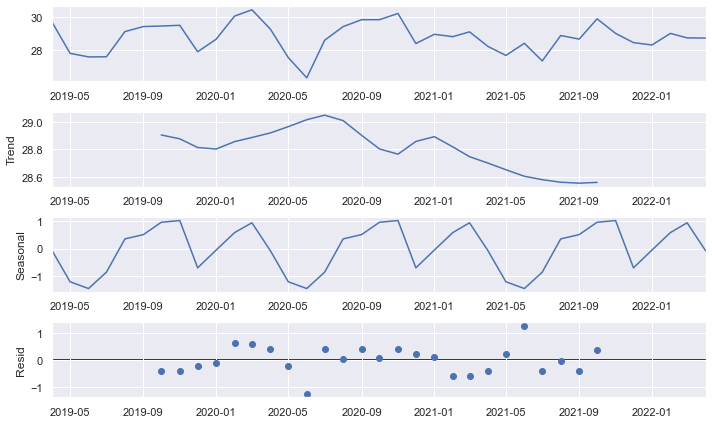

In [137]:
plot_ts_decompositions(ts_decomps, columns=['radiation', 'precipitation', 'pai', 'temperature'])

## Seasonal Decomposition for Polygon 4

In [144]:
ts_decomps = do_ts_decomposition(monthly_data, polygon_id=4, start_date=start_date, end_date=end_date, columns=['radiation', 'precipitation', 'pai', 'temperature'])

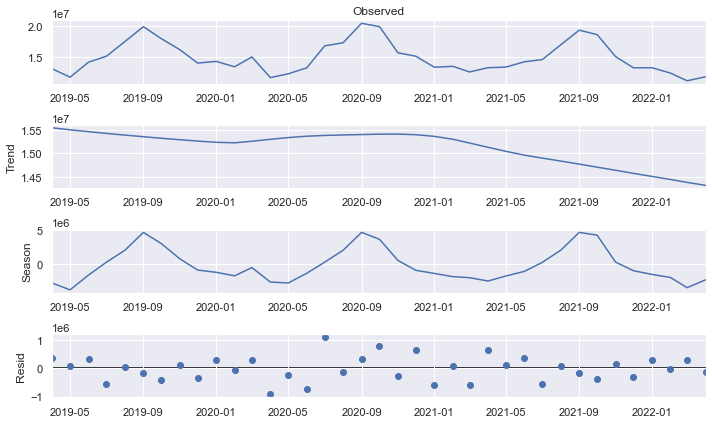

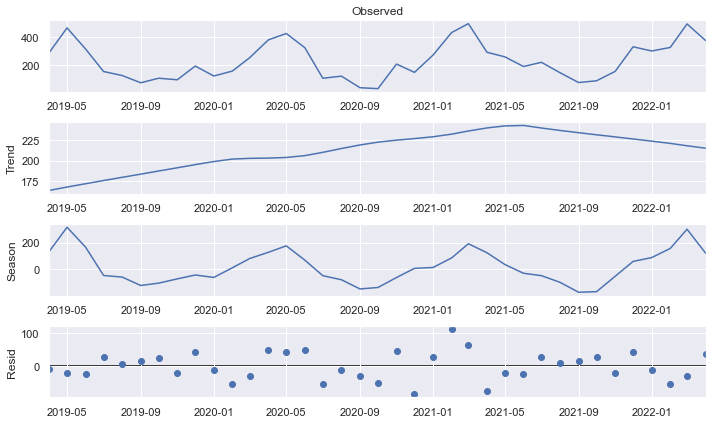

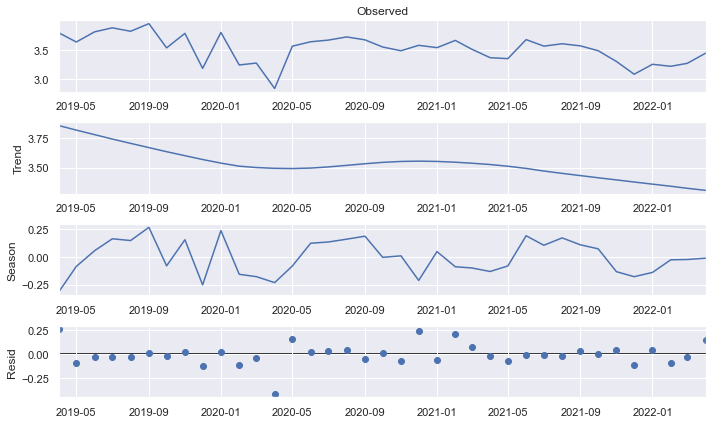

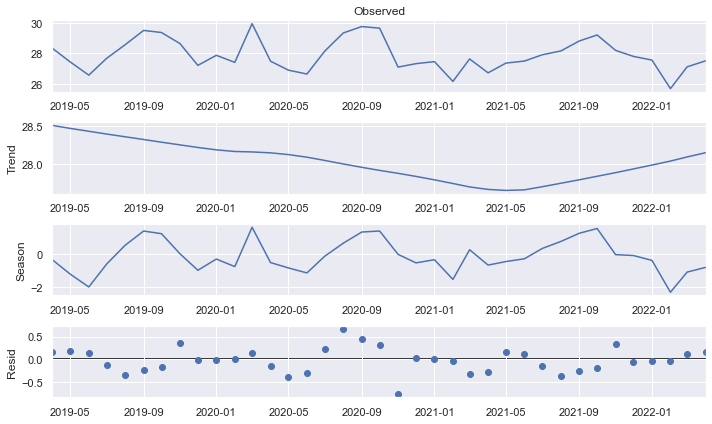

In [145]:
plot_ts_decompositions(ts_decomps, columns=['radiation', 'precipitation', 'pai', 'temperature'])

## Seasonal Decomposition for Polygon 5

In [146]:
ts_decomps = do_ts_decomposition(monthly_data, polygon_id=5, start_date=start_date, end_date=end_date, columns=['radiation', 'precipitation', 'pai', 'temperature'])

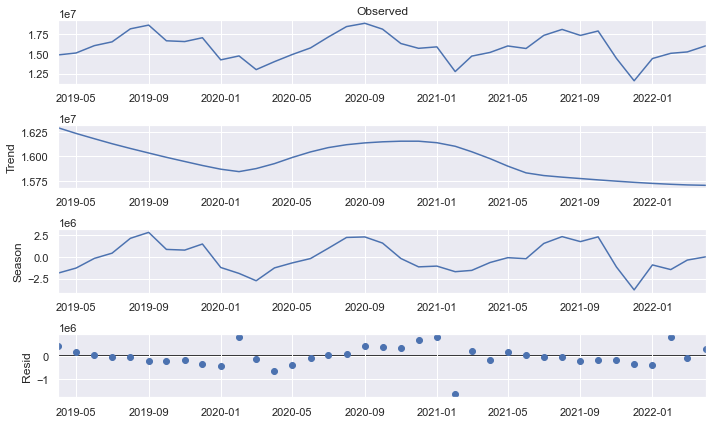

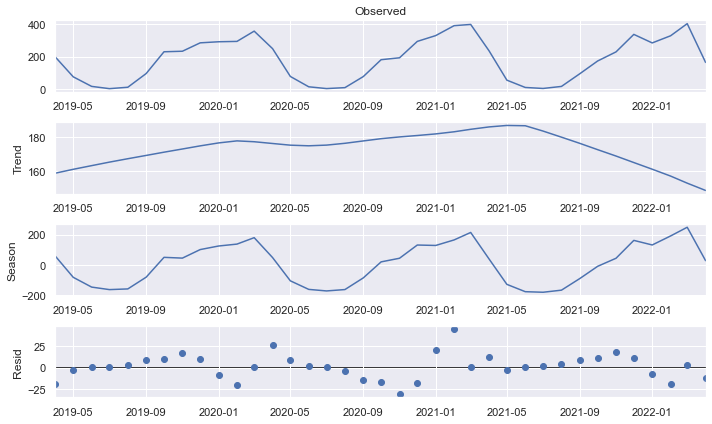

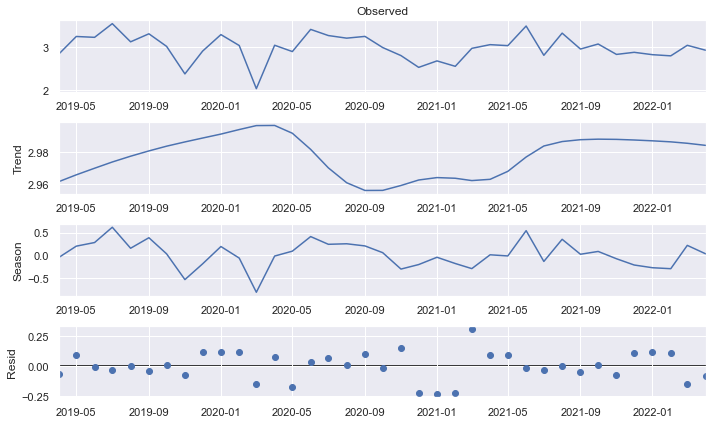

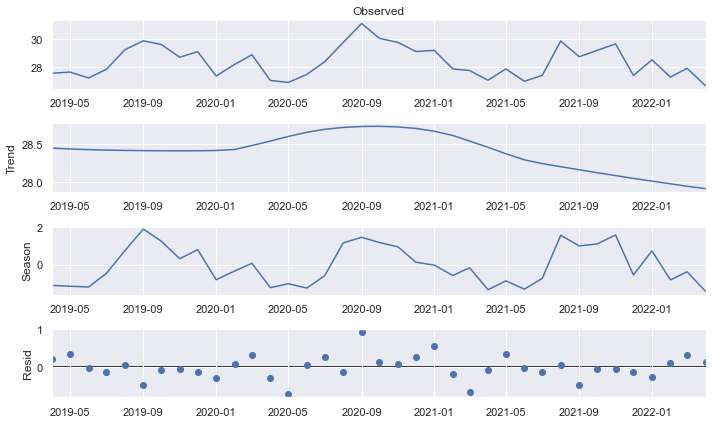

In [147]:
plot_ts_decompositions(ts_decomps, columns=['radiation', 'precipitation', 'pai', 'temperature'])

## Seasonal Decomposition for Polygon 6

In [149]:
ts_decomps = do_ts_decomposition(monthly_data, polygon_id=6, start_date=start_date, end_date=end_date, columns=['radiation', 'precipitation', 'pai', 'temperature'])

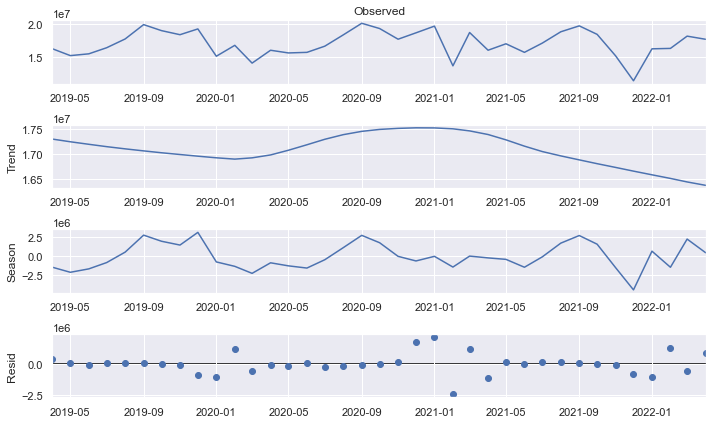

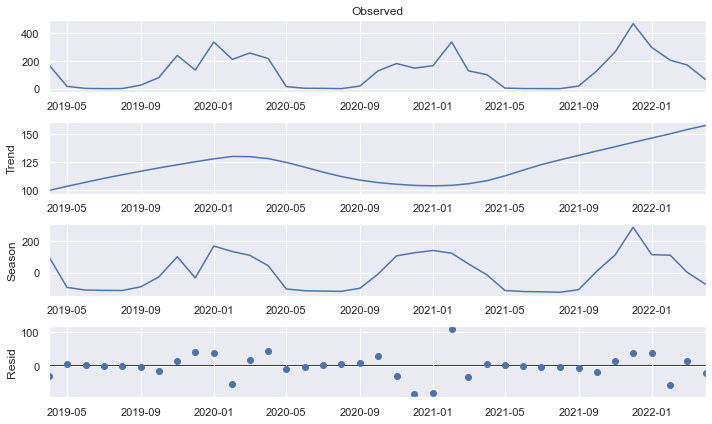

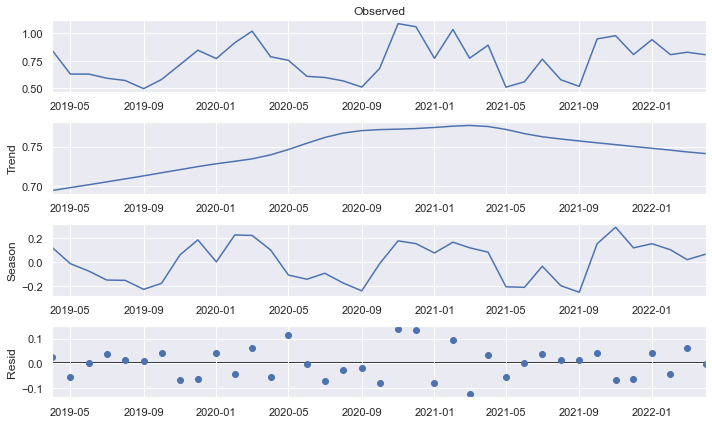

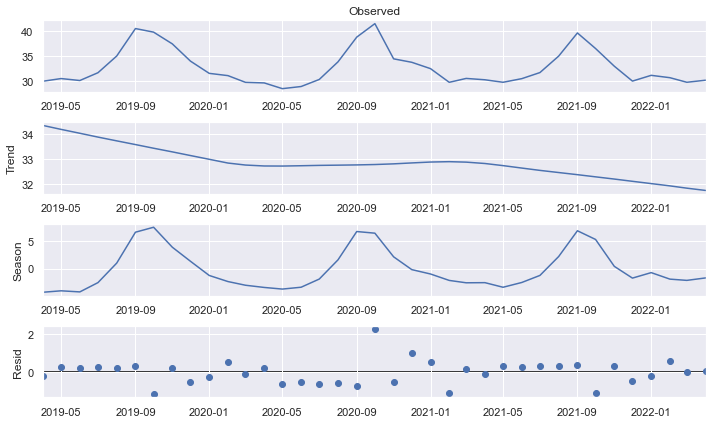

In [150]:
plot_ts_decompositions(ts_decomps, columns=['radiation', 'precipitation', 'pai', 'temperature'])

## Seasonal Decomposition for Polygon 7

In [152]:
ts_decomps = do_ts_decomposition(monthly_data, polygon_id=7, start_date=start_date, end_date=end_date, columns=['radiation', 'precipitation', 'pai', 'temperature'])

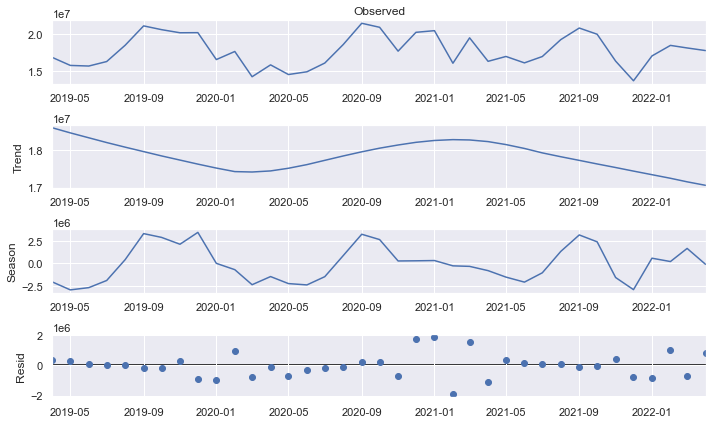

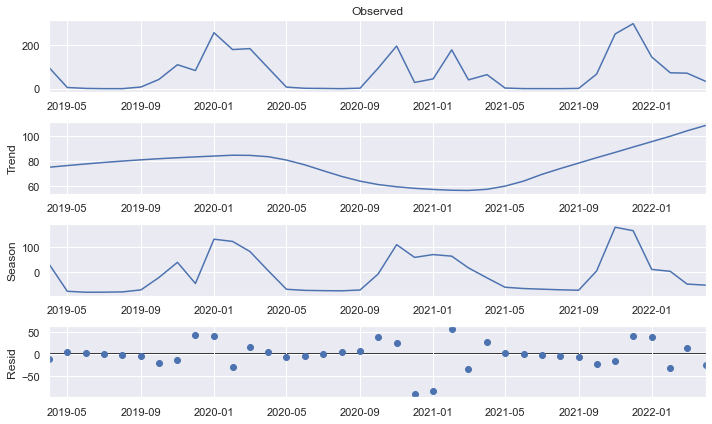

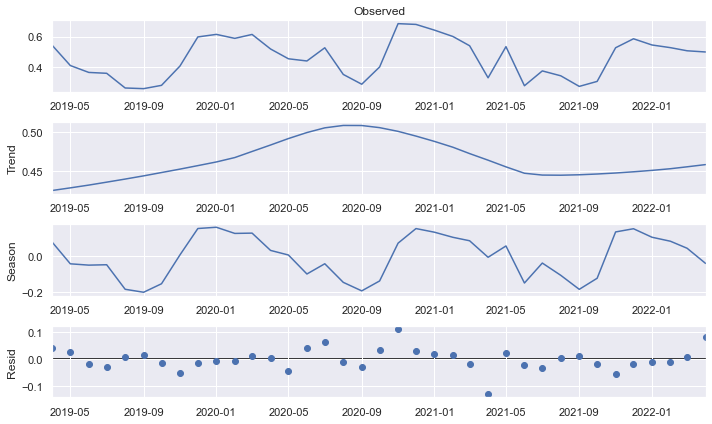

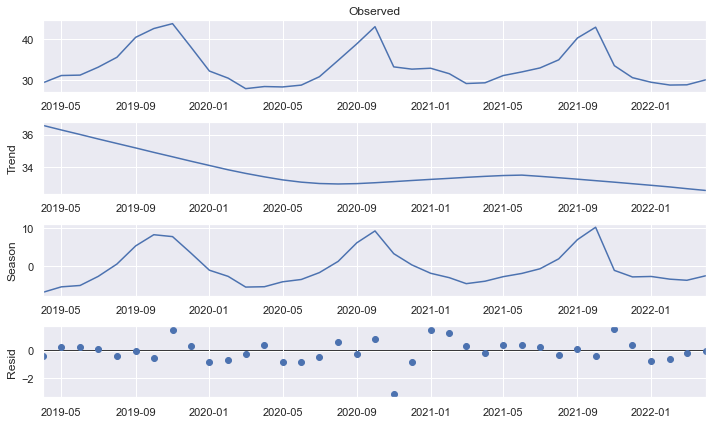

In [153]:
plot_ts_decompositions(ts_decomps, columns=['radiation', 'precipitation', 'pai', 'temperature'])

## Seasonal Decomposition for Polygon 8

In [154]:
ts_decomps = do_ts_decomposition(monthly_data, polygon_id=8, start_date=start_date, end_date=end_date, columns=['radiation', 'precipitation', 'pai', 'temperature'])

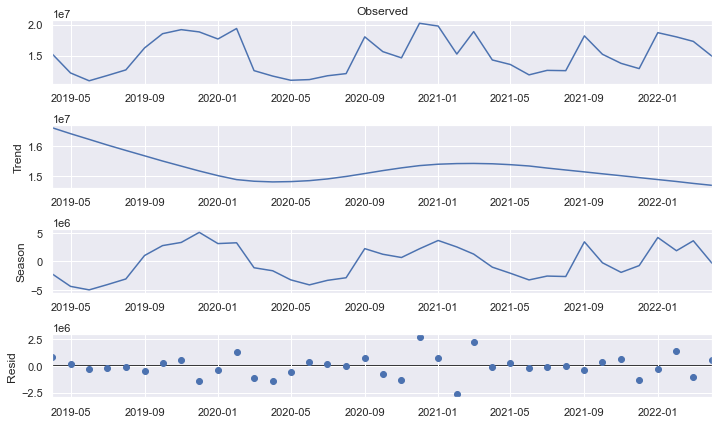

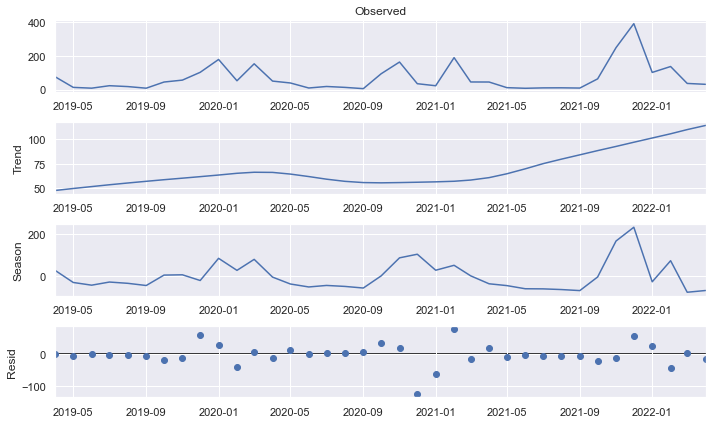

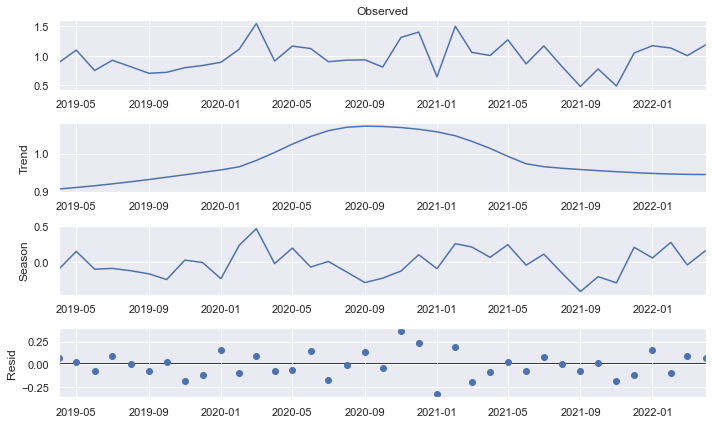

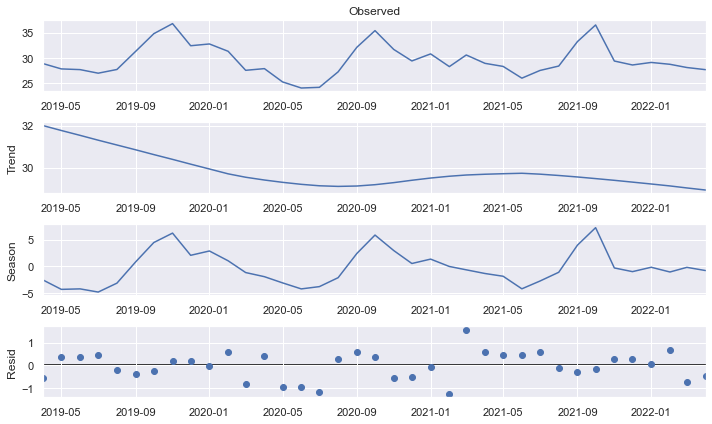

In [155]:
plot_ts_decompositions(ts_decomps, columns=['radiation', 'precipitation', 'pai', 'temperature'])